In [ ]:
Assume satellite is nadir-pointing thus one solar panel faces sun at angle relative to nadir axis. 
Minimum baseline power production assumption. Every two angle measurements from simulation datasheet corresponds to a single orbit. 
Model based on time period from: April 2020 - May 2020

In [6]:
import pandas as pd
import math 
import matplotlib.pyplot as plt

solar_irradiance = 1380
area = 0.003
efficiency = 0.24

to_nadir_angles = pd.read_csv("to_nadir_angles.csv")['To Nadir Angle (deg)'] 
to_nadir_angles

0        35.267
1       149.195
2        93.298
3        24.539
4       138.163
         ...   
1436    161.798
1437     60.595
1438     58.971
1439    161.080
1440     71.300
Name: To Nadir Angle (deg), Length: 1441, dtype: float64

In [7]:
def calculate_solar_power(angles):
    
    total_solar_power = 0
    remaining_solar_power = []
    orbit_power_tracker = 0 
    solar_power_orbit = []
    iterator = []
    
    for i in range(len(angles)):
        
        #Nadir angle gets updated every 30-minutes, satellite receives sunlight for 60-minutes per orbit
        #Two iterations of nadir angle thus correspond to power produced per single orbit; track using modulus op 
        
        total_solar_power += math.sqrt(pow((solar_irradiance * area * efficiency * math.cos((angles[i])*math.pi/180) * 4 * 1000) * 30 / 60, 2))
        orbit_power_tracker += math.sqrt(pow((solar_irradiance * area * efficiency * math.cos((angles[i])*math.pi/180) * 4 * 1000) * 30 / 60, 2))
        
        if i % 2 == 0:
            solar_power_orbit.append(orbit_power_tracker)
            orbit_power_tracker = 0 #reset temp var upon completion of single orbit (two iterations)
            iterator.append(i/2)
            
    return total_solar_power, solar_power_orbit, iterator

In [ ]:
Display array containing power production (mWh) per orbit
Graph shown below represents peaks and troughs in power production over multiple orbits; 
if zoomed in graph will show more oscillations due to varying angle to nadir-axis

In [8]:
total_power, power_per_orbit, iterator = calculate_solar_power(to_nadir_angles)
power_per_orbit

[1622.4897340426992,
 1821.1582872603144,
 3288.267937679153,
 2420.9387355841673,
 2060.3136753446647,
 2825.871418074274,
 3114.9247318230555,
 1978.0593463869704,
 1925.3826068685587,
 3320.7863420214517,
 2124.216037431173,
 2015.948514214982,
 3007.35687059854,
 2938.858060125099,
 2028.7183980728485,
 2225.4178965814435,
 3293.2302677314365,
 1794.9063972972815,
 1936.4487777513903,
 3134.1870310160925,
 2725.7857959645007,
 2047.0762992440664,
 2488.3654573708486,
 3228.070205822817,
 1838.295259862658,
 1836.8279892680855,
 3224.1286286693303,
 2473.912002896145,
 2039.288641625269,
 2716.278447393931,
 3107.9517708982958,
 1922.8508529344801,
 1786.2512177086048,
 3255.3160061488616,
 2187.793136238134,
 1996.6506636603208,
 2895.3966321035396,
 2951.078395430011,
 1977.2048699679874,
 2086.3616862037543,
 3249.8716231908347,
 1878.0031071406331,
 1932.6326231891558,
 3038.9538112271175,
 2749.6606282160938,
 2005.3786835517385,
 2353.63812056037,
 3187.8414017202467,
 1764.89

In [9]:
print(total_power)

1601483.5407968792


Total power produced: 1601483.5407968792 mWh


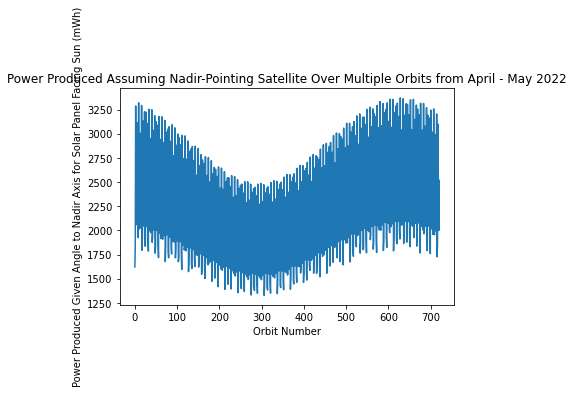

In [10]:
plt.title("Power Produced Assuming Nadir-Pointing Satellite Over Multiple Orbits from April - May 2022")   
plt.xlabel("Orbit Number")
plt.ylabel("Power Produced Given Angle to Nadir Axis for Solar Panel Facing Sun (mWh)")
plt.plot(iterator, power_per_orbit)
print("Total power produced: " + str(total_power) + " mWh")

In [ ]:
Determine power consumption per orbit and total power consumption over time considering OBC, Platform & Comms subsystems

In [11]:
magnetorquer = -600
gyro = -12
obc = -800
power_used_platform_computing = (gyro + magnetorquer + obc) / 60 * 90 #all comp will use power for entire duration of 90-min orbit
print("OBC, ADCS per orbit: " + str(power_used_platform_computing))

transmission_data = pd.read_csv("Satellite-ISS_UNITY_25575-To-Facility-London_April22_Access.csv")
mean_transmit_time = transmission_data['Duration (sec)'].mean()/60/60
print('Average transmission time (mins): April - May 2022: ' + str(mean_transmit_time) + " hours") 

uhf_transceiver_transmit = 1140
uhf_transceiver_receive = 0.0825

power_used_transceiver = uhf_transceiver_transmit/60*mean_transmit_time*(-1) + uhf_transceiver_receive/60*(90-mean_transmit_time)*(-1)
print('Power Used Transceiver: ' + str(power_used_transceiver))


OBC, ADCS per orbit: -2118.0
Average transmission time (mins): April - May 2022: 0.09202910202991453 hours
Power Used Transceiver: -1.8721763985530848


In [12]:
def calculate_net_power_remaining(angles):
    net_power_per_orbit = []
    remaining_power_per_orbit = []
    net_power = 0 
    battery_charge_counteraction = 0
    orbit_inc = 0
    for i in range(len(angles)):
        net_power_per_orbit.append(angles[i] + power_used_platform_computing + power_used_transceiver)
        net_power += net_power_per_orbit[i]
        remaining_power_per_orbit.append(net_power)
        
        #Check if energy goes into deficit, then how much battery power is required to counteract it
        #Look at change in net energy remaining and account for it if it lowers 
        temp = i - 1
        if remaining_power_per_orbit[i] < 0 and remaining_power_per_orbit[temp] < 0: 
            if remaining_power_per_orbit[i] < remaining_power_per_orbit[temp]:
                battery_charge_counteraction += remaining_power_per_orbit[i] - remaining_power_per_orbit[temp]
                orbit_inc += 1
    return net_power_per_orbit, net_power, remaining_power_per_orbit, battery_charge_counteraction, orbit_inc

In [ ]:
Display array containing net power remaining (mWh) per orbit
Graph shown below represents peaks and troughs in power over multiple orbits; 
if zoomed in graph will show more oscillations due to varying angle to nadir-axis

In [13]:
net_power_per_orbit, net_power, rem_power_orbit, power_lost, orbits_power_lost = calculate_net_power_remaining(power_per_orbit)
net_power_per_orbit

[-497.3824423558539,
 -298.7138891382387,
 1168.3957612805998,
 301.06655918561415,
 -59.55850105388837,
 705.999241675721,
 995.0525554245024,
 -141.81283001158263,
 -194.48956952999438,
 1200.9141656228985,
 4.34386103261985,
 -103.92366218357111,
 887.4846941999868,
 818.9858837265461,
 -91.15377832570462,
 105.54572018289045,
 1173.3580913328833,
 -324.9657791012716,
 -183.42339864716283,
 1014.3148546175395,
 605.9136195659477,
 -72.7958771544867,
 368.4932809722955,
 1108.198029424264,
 -281.5769165358951,
 -283.0441871304676,
 1104.2564522707771,
 354.03982649759206,
 -80.58353477328401,
 596.4062709953779,
 988.0795944997427,
 -197.02132346407294,
 -333.6209586899483,
 1135.4438297503084,
 67.92095983958106,
 -123.22151273823229,
 775.5244557049865,
 831.2062190314579,
 -142.66730643056567,
 -33.5104901947988,
 1129.9994467922816,
 -241.86906925791996,
 -187.23955320939731,
 919.0816348285645,
 629.7884518175407,
 -114.49349284681458,
 233.76594416181715,
 1067.9692253216936,
 

In [14]:
rem_power_orbit

[-497.3824423558539,
 -796.0963314940926,
 372.2994297865072,
 673.3659889721214,
 613.807487918233,
 1319.806729593954,
 2314.8592850184564,
 2173.0464550068737,
 1978.5568854768792,
 3179.4710510997775,
 3183.8149121323972,
 3079.891249948826,
 3967.375944148813,
 4786.361827875359,
 4695.208049549655,
 4800.753769732545,
 5974.1118610654285,
 5649.146081964157,
 5465.722683316994,
 6480.037537934534,
 7085.951157500482,
 7013.155280345995,
 7381.648561318291,
 8489.846590742556,
 8208.269674206662,
 7925.225487076194,
 9029.481939346972,
 9383.521765844564,
 9302.938231071279,
 9899.344502066657,
 10887.4240965664,
 10690.402773102327,
 10356.78181441238,
 11492.225644162689,
 11560.14660400227,
 11436.925091264038,
 12212.449546969025,
 13043.655766000482,
 12900.988459569917,
 12867.477969375119,
 13997.4774161674,
 13755.60834690948,
 13568.368793700081,
 14487.450428528646,
 15117.238880346187,
 15002.745387499373,
 15236.511331661191,
 16304.480556982886,
 15949.502650846705,
 

Remaining power: 73055.70161352323 mWh
Net Power Remaining in Deficit for 100 consecutive orbits -39928.67552255913 mWh energy lost


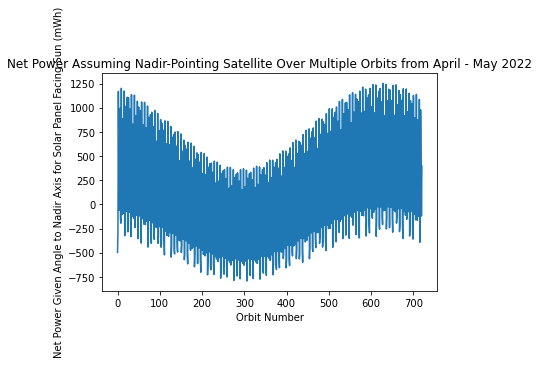

In [15]:
print("Remaining power: " + str(net_power) + " mWh")
print("Net Power Remaining in Deficit" + " for " + str(orbits_power_lost) + " consecutive orbits " + str(power_lost) + " mWh energy lost")
plt.title("Net Power Assuming Nadir-Pointing Satellite Over Multiple Orbits from April - May 2022")   
plt.xlabel("Orbit Number")
plt.ylabel("Net Power Given Angle to Nadir Axis for Solar Panel Facing Sun (mWh)")
plt.plot(iterator, net_power_per_orbit)

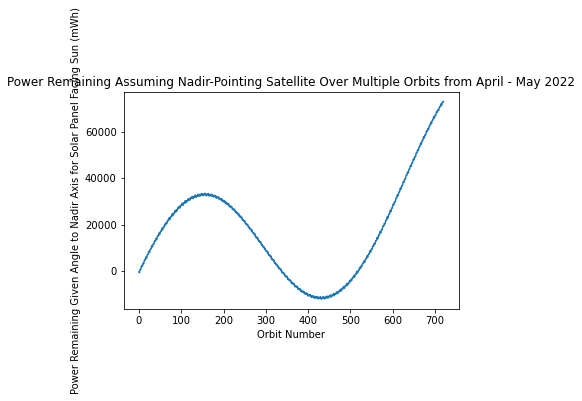

In [12]:
plt.title("Power Remaining Assuming Nadir-Pointing Satellite Over Multiple Orbits from April - May 2022")   
plt.xlabel("Orbit Number")
plt.ylabel("Power Remaining Given Angle to Nadir Axis for Solar Panel Facing Sun (mWh)")
plt.plot(iterator, rem_power_orbit)